In [1]:
from graph_tool.centrality import betweenness, closeness
from numpy import NaN
from random import random
import pandas as pd
from graph_tool.all import *
from graph_tool.clustering import *

In [2]:
df = pd.read_csv("soc-sign-bitcoinotc.csv")
print(df.head())

   source  target  rating          time
0       6       2       4  1.289242e+09
1       6       5       2  1.289242e+09
2       1      15       1  1.289243e+09
3       4       3       7  1.289245e+09
4      13      16       8  1.289254e+09


In [3]:
g = Graph(directed=True)
g.vp['name'] = g.new_vp('string')
g.ep['weight'] = g.new_ep('int')
g.ep['timestamp'] = g.new_ep('float')
nodes = set()

for i,row in df.iterrows():
    a,b,c,d = row
    nodes.add(a)
    nodes.add(b)
for n in nodes:
    v = g.add_vertex()
    g.vp['name'][v] = n
nodes = list(nodes)
for i,row in df.iterrows():
    a,b,c,d = row
    s = nodes.index(a)
    t = nodes.index(b)
    vs = g.vertex(s)
    vt = g.vertex(t)
    e = g.add_edge(vs, vt)
    g.ep['weight'][e] = c
    g.ep['timestamp'][e] = d
print("Vertex count:",g.num_vertices())
print("Edge count:",g.num_edges())

Vertex count: 5881
Edge count: 35592


In [4]:
def bfs_color(g, v, color):
    visit = [v]
    nNode = 0
    while len(visit) != 0:
        a = visit[0]
        visit.remove(a)
        nNode = nNode +1
        plot_color[a] = color
        for e in a.out_neighbors():
            if e not in visit and plot_color[e] != color:
                visit.append(e)
        for e in a.in_neighbors():
            if e not in visit and plot_color[e] != color:
                visit.append(e)
    return nNode

In [5]:
plot_color = g.new_vp('string')
g.vp['plot_color'] = plot_color

colors = ['red', 'blue', 'green', 'yellow']

for v in g.vertices():
    plot_color[v] = 'black'

color_i = 0
components = []
for v in g.vertices():
    if not (plot_color[v] in colors):
        if color_i >= len(colors):
            raise Exception("Not enough colors")
        components.append(v)
        bfs_color(g, v, colors[color_i])
        color_i = color_i +1

In [6]:
print("Number of connected components: "+str(color_i))

Number of connected components: 4


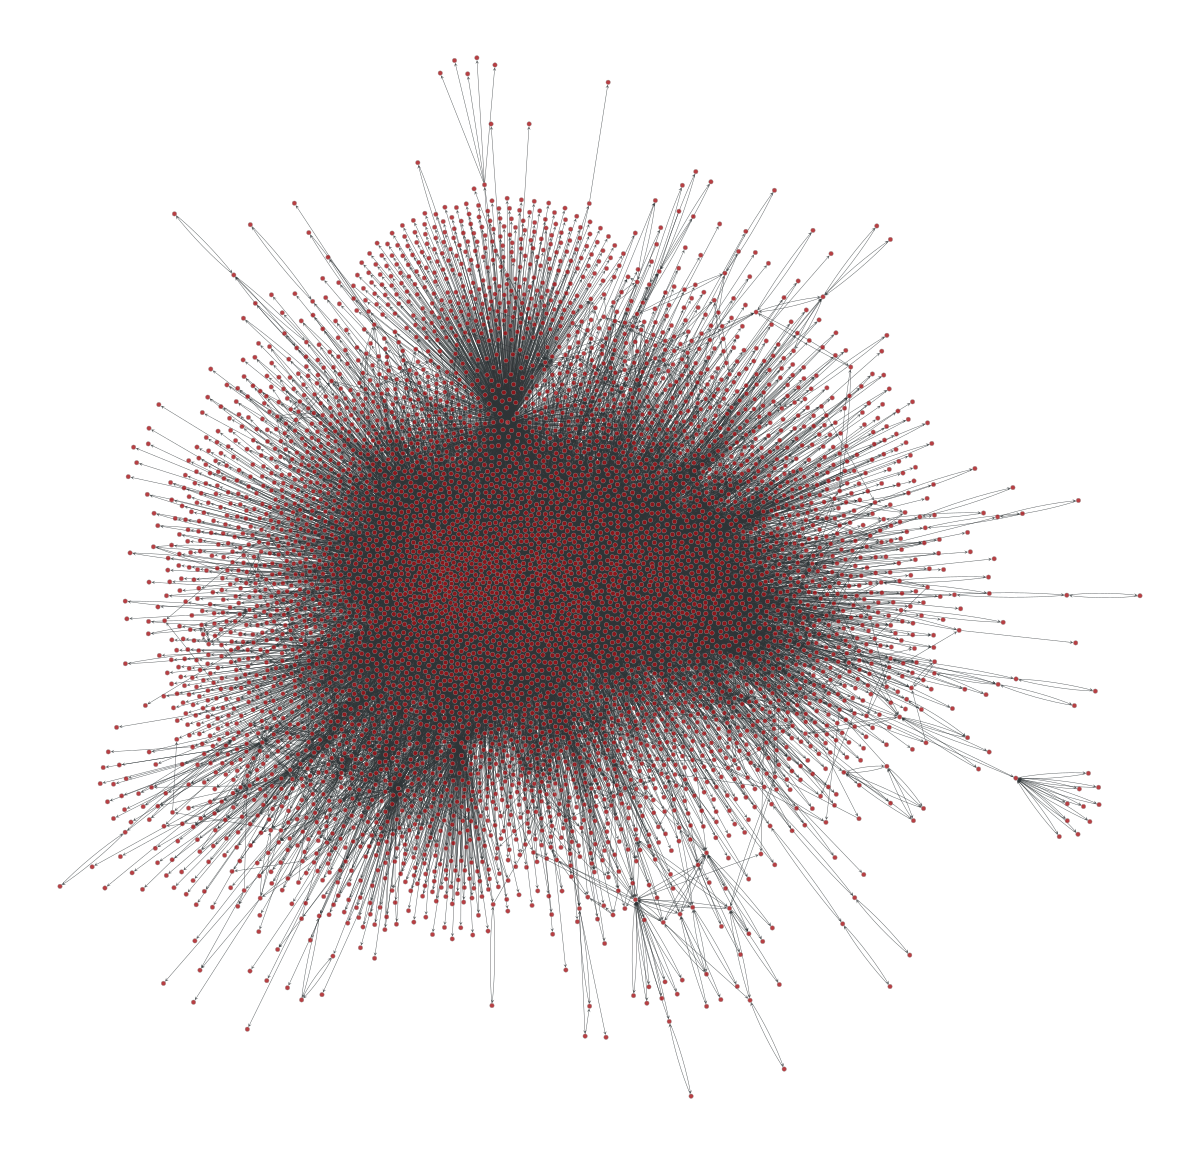

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3354d62b20, at 0x7f3354d62160>

In [7]:
vfilt = g.new_vertex_property('bool')
for v in g.vertices():
    vfilt[v] = (plot_color[v] == 'red')
u = GraphView(g, vfilt)
graph_draw(u)

In [8]:
print(u.num_vertices())

5875


Most significant motif:


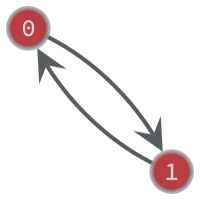

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f33880ef6d0, at 0x7f3354532f40>

In [9]:
f = motifs(u,k=2)
ind = f[1].index(max(f[1]))
print("Most significant motif:")
graph_draw(f[0][ind], vertex_text=f[0][ind].vertex_index,output_size=(100, 100))

Most significant motif:


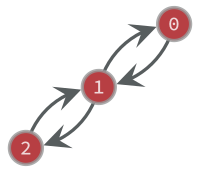

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3354d327f0, at 0x7f3354d440a0>

In [10]:
f = motifs(u,k=3)
ind = f[1].index(max(f[1]))
print("Most significant motif:")
graph_draw(f[0][ind], vertex_text=f[0][ind].vertex_index,output_size=(100, 100))

In [11]:
def compute_fairness_goodness(G, it):
    fairness = {}
    goodness = {}
    for i in G.nodes():
        fairness[i] = 1
        goodness[i] = 1
    nodes = G.nodes()
    iter = 0
    while iter < it:
        df = 0
        dg = 0
        for node in nodes:
            inedges = G.in_edges(node, data='weight')
            g = 0
            for edge in inedges:
                g += fairness[edge[0]]*edge[2]
            try:
                dg += abs(g/len(inedges) - goodness[node])
                goodness[node] = g/len(inedges)
            except:
                pass
        for node in nodes:
            outedges = G.out_edges(node, data='weight')
            f = 0
            for edge in outedges:
                f += 1.0 - abs(edge[2] - goodness[edge[1]])/2.0
            try:
                df += abs(f/len(outedges) - fairness[node])
                fairness[node] = f/len(outedges)
            except:
                pass
        if df < math.pow(10, -6) and dg < math.pow(10, -6):
            break
        iter+=1
    return fairness, goodness

In [12]:
import networkx as nx
import math
G = nx.DiGraph()
f = open("soc-sign-bitcoinotc.csv","r")
for l in f:
    if "source" in l:
        pass
    else:
        ls = l.strip().split(",")
        G.add_edge(int(ls[0]), int(ls[1]), weight = float(ls[2])/10) ## the weight should already be in the range of -1 to 1
f.close()
fairness, goodness = compute_fairness_goodness(G,10000)
badguys = set()
for i in goodness:
    if goodness[i] < 0:
        badguys.add(int(i))
        

In [13]:
g.vp['good'] = g.new_vp('int')
for i in g.vertices():
    if int(float(g.vp['name'][i])) in badguys:
        g.vp['good'][i] = -1
    else:
        g.vp['good'][i] = 1
graph_draw(g, output_size=(3000, 1500),vertex_fill_color = g.vp['good'], edge_color = g.ep['weight'], output="prova1.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3354d68e20, at 0x7f334c1c1ee0>

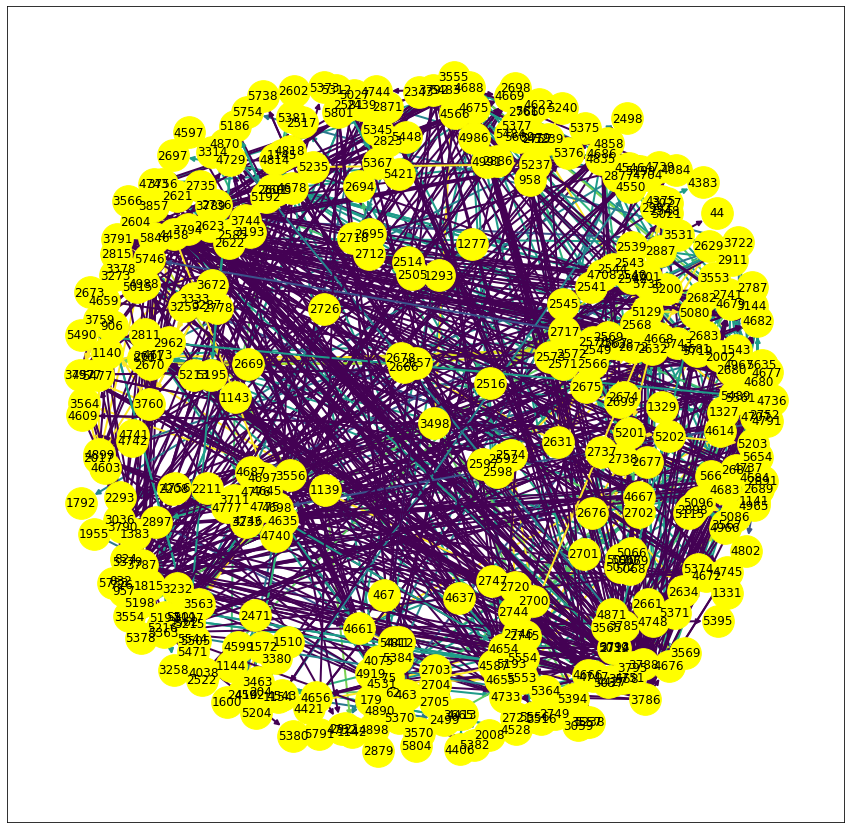

In [14]:
import matplotlib.pyplot as plt
G1 = nx.DiGraph()
badguys_color = []
for i,j,dt in G.edges(data = True):
    if i in badguys and j in badguys:
        G1.add_node(i)
        G1.add_node(j)
        G1.add_edge(i,j,weight = dt['weight'])
plt.figure(figsize=(15, 15))
edges,weights = zip(*nx.get_edge_attributes(G1,'weight').items())
nx.draw_networkx(G1,with_labels = True,#pos = nx.circular_layout(G1), 
            edge_color = weights,
            width=2.0,node_color = "yellow", node_size= 1000)
plt.rcParams['axes.facecolor']='white'
plt.savefig("drawings/output.png")

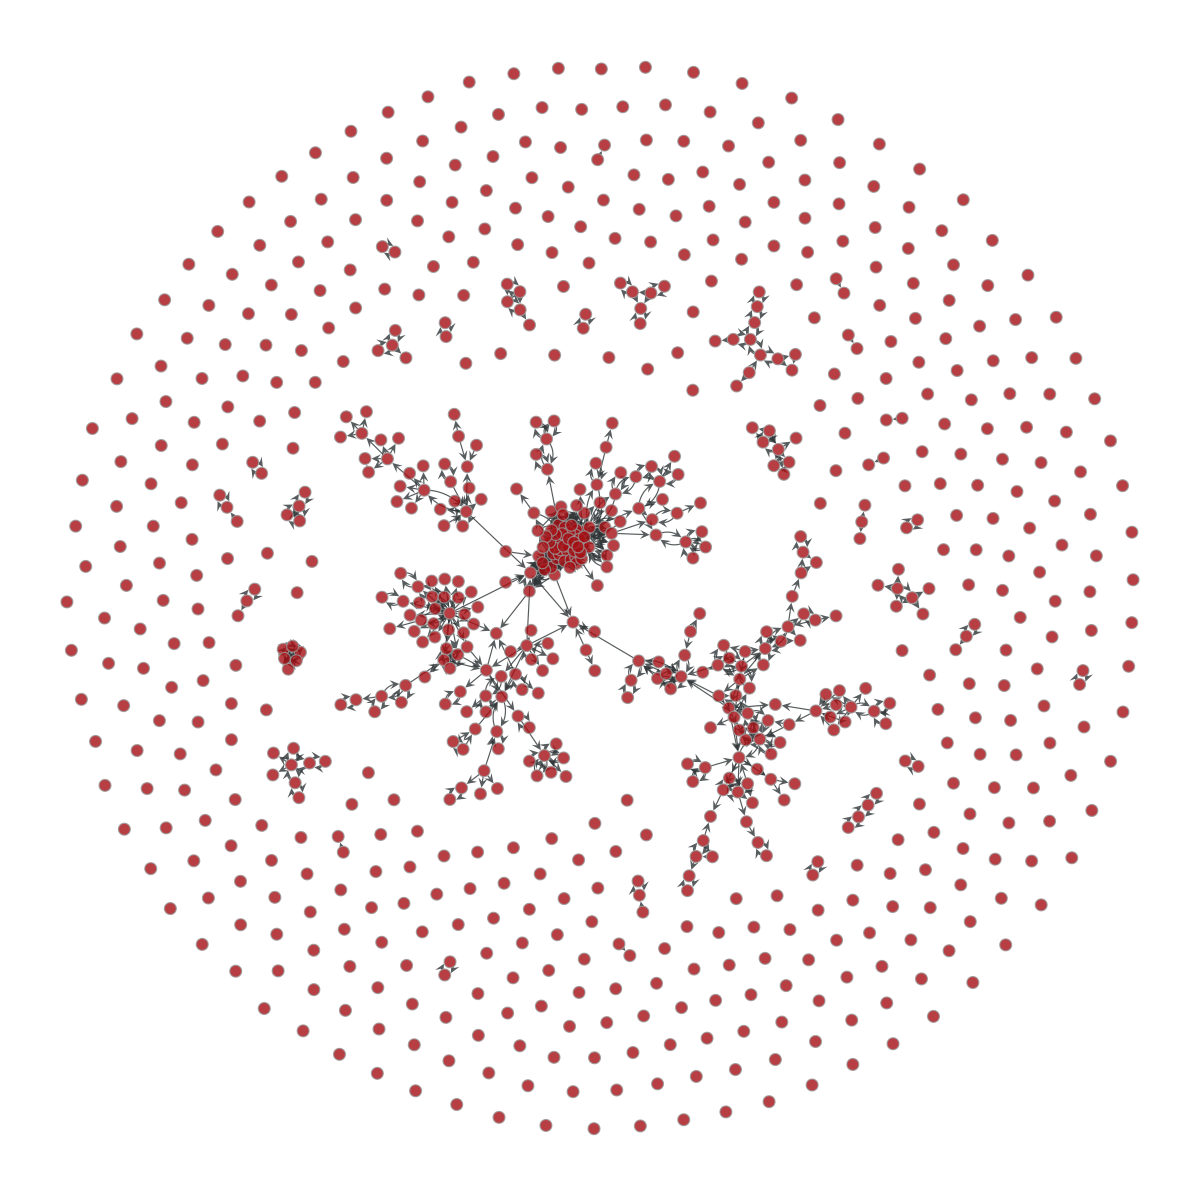

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3346e6cca0, at 0x7f3346e0efd0>

In [15]:
badfilt = g.new_vertex_property('bool')
for v in g.vertices():
    badfilt[v] = (g.vp['good'][v] == -1)
bad = GraphView(g, badfilt)
graph_draw(bad)

In [16]:
print(bad.num_vertices())
print(len(G1.nodes()))

828
394


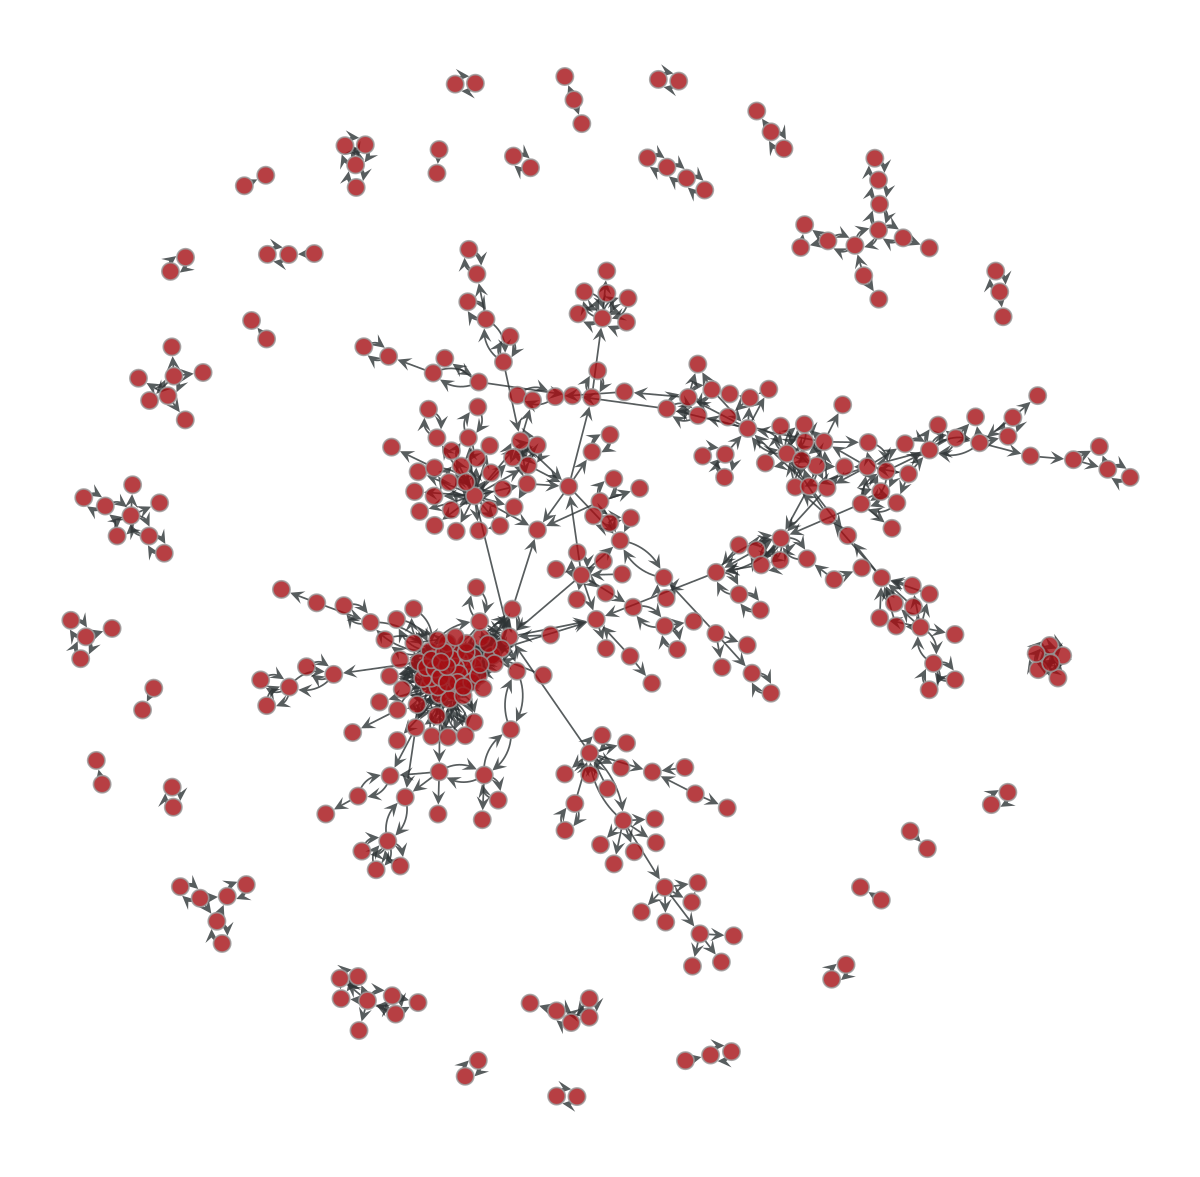

394


In [17]:
connected = g.new_vertex_property('bool')
for v in bad.vertices():
    for u in v.out_neighbors():
        connected[v] = (u in bad.vertices())
    for u in v.in_neighbors():
        connected[v] = connected[v] or (u in bad.vertices())
bad_connected = GraphView(bad, connected)
graph_draw(bad_connected)
print(bad_connected.num_vertices())

In [19]:
bad_g = Graph(directed=True)
bad_g.vp['name'] = bad_g.new_vp('string')
bad_g.ep['weight'] = bad_g.new_ep('int')
bad_g.ep['timestamp'] = bad_g.new_ep('float')
for v in g.vertices():
    if connected[v] == 1:
        v = bad_g.add_vertex()
        bad_g.vp['name'][v] = g.vp['name'][v]
print(bad_g.num_vertices())

394


In [35]:
g2 = Graph(bad_connected)
print(g2.num_vertices())
graph_draw(g2, output="drawings/bad_connected.png")

394


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3346e654f0, at 0x7f3355e78e80>

In [36]:
f = motifs(g2,k=2)
ind = f[1].index(max(f[1]))
print("Most significant motif:")
graph_draw(f[0][ind], vertex_text=f[0][ind].vertex_index,output_size=(100, 100), output="drawings/motif_2_bad_connected.png")

Most significant motif:


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3346e68100, at 0x7f3354d62d00>

In [37]:
f = motifs(g2,k=3)
ind = f[1].index(max(f[1]))
print("Most significant motif:")
graph_draw(f[0][ind], vertex_text=f[0][ind].vertex_index,output_size=(100, 100), output="drawings/motif_3_bad_connected.png")

Most significant motif:


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f33880efe80, at 0x7f3346e65280>